# Language Indentification

In [1]:
# Importing Required ibraries
from scipy.io import wavfile
import warnings
import zipfile
import pandas as pd
from sklearn import preprocessing
import os
warnings.filterwarnings("ignore")

### Extracting the Zip file

In [2]:
raw_file_path = '/home/vibhav911/Documents/DS_Projects/NLP/language-identification/data/language-audio-data.zip'
target_dir = "/home/vibhav911/Documents/DS_Projects/NLP/language-identification/data/final_data"
os.makedirs(target_dir, exist_ok=True)

with zipfile.ZipFile(raw_file_path, "r") as zip_f:
    zip_f.extractall(target_dir)

### Checking the number of files in each class

In [3]:
audio_dir1 = os.path.join(target_dir, "language-audio-data")
os.listdir(audio_dir1)

['Kannada', 'Hindi', 'Tamil', 'Telugu']

In [4]:
classes = []
for i in os.listdir(audio_dir1):
    classes.append(i)
    class_path = audio_dir1 + "/" + str(i)
    audio_clips = os.listdir(class_path)
    print(f"No of .wav files in audio {i} folder =", len(audio_clips) )

No of .wav files in audio Kannada folder = 1001
No of .wav files in audio Hindi folder = 1001
No of .wav files in audio Tamil folder = 1001
No of .wav files in audio Telugu folder = 1001


### To convert MP3 to wave

In [5]:
'''om os import path
from pydub import AudioSegment

os.makedirs("final_wav", exist_ok=True)

for folder in os.listdir(audio_dir1):
    class_path = audio_dir1 + "/" + str(folder)
    for count, files in enumerate(os.listdir(class_path)):
        src = f'{audio_dir1}/{folder}/{files}'
        file_name = f"{folder}-{str(count)}.wav"
        dst = f"final_wav/{folder}"
        os.makedirs(dst, exist_ok=True)
        dst = f"final_wav/{folder}/{file_name}"
        sound = AudioSegment.from_mp3(src)
        sound.export(dst, format="wav")
'''    

'om os import path\nfrom pydub import AudioSegment\n\nos.makedirs("final_wav", exist_ok=True)\n\nfor folder in os.listdir(audio_dir1):\n    class_path = audio_dir1 + "/" + str(folder)\n    for count, files in enumerate(os.listdir(class_path)):\n        src = f\'{audio_dir1}/{folder}/{files}\'\n        file_name = f"{folder}-{str(count)}.wav"\n        dst = f"final_wav/{folder}"\n        os.makedirs(dst, exist_ok=True)\n        dst = f"final_wav/{folder}/{file_name}"\n        sound = AudioSegment.from_mp3(src)\n        sound.export(dst, format="wav")\n'

### Rename the files

In [6]:
# rename the files so that there are no duplicates while loading the data
for folder in os.listdir(audio_dir1):
    class_path = audio_dir1 + '/' + str(folder)
    for count, files in enumerate(os.listdir(class_path)):
        try:
            dst = f"{folder}1-{str(count)}.wav"
            src = f"{audio_dir1}/{folder}/{files}"
            dst = f"{audio_dir1}/{folder}/{dst}"
            os.rename(src, dst)
        except FileExistsError:
            pass

### Create Metadata for your dataset

In [7]:
wav_dir = "/home/vibhav911/Documents/DS_Projects/NLP/language-identification/data/final_data/language-audio-data"

metadata = {}
for label in os.listdir(wav_dir):
    class_path = wav_dir + '/' + str(label)
    audio_clips = os.listdir(class_path)
    for filename in audio_clips:
        metadata[filename] = label

# Create a metadata csv file
metadata = pd.DataFrame.from_dict(metadata, orient="index").reset_index().sort_values(by=0)
metadata.columns = ['filename', 'foldername']
le = preprocessing.LabelEncoder()
metadata['labels'] = le.fit_transform(metadata.foldername)
metadata.to_csv("/home/vibhav911/Documents/DS_Projects/NLP/language-identification/data/metadata.csv", index=False)
metadata

,filename,foldername,labels
2001,Hindi1-554.wav,Hindi,0
1343,Hindi1-875.wav,Hindi,0
1342,Hindi1-446.wav,Hindi,0
1341,Hindi1-467.wav,Hindi,0
1340,Hindi1-609.wav,Hindi,0
...,...,...,...
3342,Telugu1-872.wav,Telugu,3
3343,Telugu1-975.wav,Telugu,3
3344,Telugu1-464.wav,Telugu,3
3331,Telugu1-361.wav,Telugu,3


### Check the mappings

In [8]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Hindi': 0, 'Kannada': 1, 'Tamil': 2, 'Telugu': 3}


### Custom Pytorch Dataset

In [9]:
# IMporting libraries
import torch
from torch.utils.data import Dataset
import torchaudio
import pandas as pd

In [10]:
class IndianLanguageDataset(Dataset):
  def __init__(self, metadata, audio_dir, target_sample_rate, num_samples, transformation):
    self.annotations = pd.read_csv(metadata)
    self.audio_dir = audio_dir
    self.target_sample_rate = target_sample_rate
    self.num_samples = num_samples
    self.transformation = transformation
    
  def __len__(self):
    return len(self.annotations)

  def __getitem__(self,idx):
    audio_sample_path = self._get_audio_sample_path(idx)
    label = self._get_audio_sample_label(idx)
    signal, sample_rate = torchaudio.load(audio_sample_path)
    signal = self.resample_audio(signal, sample_rate)
    signal = self.mix_down_channels(signal)
    signal = self.cut_if_needed(signal)
    signal = self.right_padding(signal)
    signal = self.transformation(signal)
    return signal , label
  
  def _get_audio_sample_path(self,idx):
    class_name = f"{self.annotations.iloc[idx, 1]}"
    path = os.path.join(self.audio_dir, class_name, self.annotations.iloc[idx, 0])
    return path
  
  def _get_audio_sample_label(self, idx):
    return self.annotations.iloc[idx, 2]
  
  def resample_audio(self, signal, sample_rate):
    if sample_rate != self.target_sample_rate:
        resampler = torchaudio.transforms.Resample(sample_rate, self.target_sample_rate)
        signal = resampler(signal)
    return signal
  
  def mix_down_channels(self, signal):
    if signal.shape[0] > 1:
        signal = torch.mean(signal, dim = 0, keepdim=True)
    return signal
  
  def cut_if_needed(self, signal):
    if signal.shape[1] > self.num_samples:
        signal = signal[:, :self.num_samples]
    return signal 
  
  def right_padding(self, signal):
    length_signal = signal.shape[1]
    if length_signal < self.num_samples:
        num_missing = self.num_samples - length_signal
        last_dim_padding = (0, num_missing)
        signal = torch.nn.functional.pad(signal, last_dim_padding)
    return signal

In [11]:
signal, sample_rate = torchaudio.load('/home/vibhav911/Documents/DS_Projects/NLP/language-identification/data/final_data/language-audio-data/Hindi/Hindi1-79.wav')

In [12]:
signal.shape

torch.Size([2, 239087])

In [13]:
# Create MEL spectogram transformation
SAMPLE_RATE = 48000
NUM_SAMPLES = 240000

mel_spectogram = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE)

### Test Custom Dataset

In [14]:
ild = IndianLanguageDataset(metadata="/home/vibhav911/Documents/DS_Projects/NLP/language-identification/data/metadata.csv",
                            audio_dir= wav_dir,
                            target_sample_rate=SAMPLE_RATE,
                            transformation=mel_spectogram,
                            num_samples=NUM_SAMPLES)
print(f"there are {len(ild)} samples in the dataset")

there are 4004 samples in the dataset


In [15]:
specgram, label = ild[14]

In [16]:
print(f"signal: {specgram.shape} \n label: {label}")

signal: torch.Size([1, 128, 1201]) 
 label: 0


In [17]:
b = specgram.squeeze()
b.shape

torch.Size([128, 1201])

### Visualize the Spectrogram

In [18]:
import matplotlib.pyplot as plt
from IPython.display import Audio

def plot_spectrogram(specgram, title=None, ylabel = "freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(specgram.squeeze(), origin='lower', aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

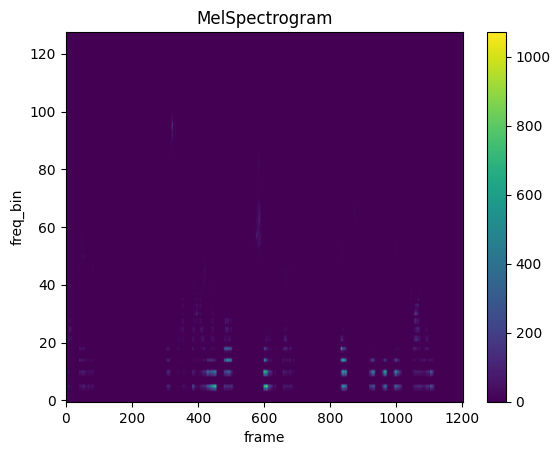

In [19]:
plot_spectrogram(specgram, title="MelSpectrogram")

In [20]:
sample_data, sample_rate = torchaudio.load('/home/vibhav911/Documents/DS_Projects/NLP/language-identification/data/final_data/language-audio-data/Hindi/Hindi1-79.wav')

In [21]:
sample_data.shape

torch.Size([2, 239087])

## CNN Model

In [22]:
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)         # Calculate accuracy
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracy
        return {'val_loss': epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item()/len(preds))
        
    

### Model Architecture

In [23]:
class CNNNetwork(ImageClassification):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = self.conv_block(in_channels, 16, pool=True)
        self.conv2 = self.conv_block(16, 32, pool=True)
        self.conv3 = self.conv_block(32, 64, pool=True)
        self.conv4 = self.conv_block(64, 128, pool=True)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64*12*12, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax(dim=1)

    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=2),
                  nn.BatchNorm2d(out_channels),
                  nn.ReLU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(kernel_size=2))
        return nn.Sequential(*layers)

    def forward(self, input_data):
        out = self.conv1(input_data)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.flatten(out)
        logits = self.linear(out)
        logits = self.relu(logits)
        predictions = self.softmax(logits)
        return predictions

In [24]:
cnn = CNNNetwork(in_channels = 1, num_classes = 4)

In [25]:
#summary(cnn.cuda(), (1,62,40))

### GPU Functions

In [26]:
def get_default_device():
    """ Pick GPU if available, else CPU """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """ Move tensor(s) to chosen device """
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class GPUDataLoader():
    """ Wrap a pytorch Dataloader to move data to a device """
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """ Yield a batch of data after moving it to device """
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """ Number of batches """
        return len(self.dl)

### Training Function

In [27]:
from torch.optim.lr_scheduler import MultiStepLR
from tqdm import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(model, train_loader, val_loader, epochs, lr, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = MultiStepLR(optimizer=optimizer,
                            milestones=[500],
                            gamma=0.1)
    for epoch in range(1, epochs+1):
        # Training
        print("Epoch:", epoch, "LR:", scheduler.get_last_lr())
        train_losses = []
        model.train()
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        for batch_idx, batch in loop:
            loss = model.training_step(batch)
            train_losses.append(loss)

            # Backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent
            optimizer.step()
            scheduler.step()

            # update progress bar
            loop.set_description(f"Epoch [{epoch}/{epochs}]")
            loop.set_postfix(loss = loss.item())

        # validation steps
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Make Stratified split of data to have same number of samples per each class

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=5, train_size=0.7, test_size=0.3, random_state=36)
for train_index, test_index in split.split(metadata, metadata['labels']):
    strat_train_set = metadata.loc[train_index]
    strat_val_set = metadata.loc[test_index]

strat_train_set.to_csv("/home/vibhav911/Documents/DS_Projects/NLP/language-identification/data/metadata_train.csv", index=False)
strat_val_set.to_csv("/home/vibhav911/Documents/DS_Projects/NLP/language-identification/data/metadata_val.csv", index=False)

In [29]:
torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1650'

### Move model objects to GPU
#### dataloader, model -> GPU

In [30]:
BATCH_SIZE = 64
SAMPLE_RATE = 4000
NUM_SAMPLES = 20000

mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE,
                                                       n_fft = 1024,
                                                       hop_length= 512,
                                                       n_mels = 64)

# Adam Optimiser
optimiser = torch.optim.Adam

train_lang_data = IndianLanguageDataset(metadata = "/home/vibhav911/Documents/DS_Projects/NLP/language-identification/data/metadata_train.csv",
                                        audio_dir=wav_dir,
                                        target_sample_rate=SAMPLE_RATE,
                                        transformation= mel_spectogram,
                                        num_samples= NUM_SAMPLES)

val_lang_data = IndianLanguageDataset(metadata = "/home/vibhav911/Documents/DS_Projects/NLP/language-identification/data/metadata_val.csv",
                                      audio_dir=wav_dir,
                                      target_sample_rate=SAMPLE_RATE,
                                      transformation=mel_spectogram,
                                      num_samples=NUM_SAMPLES)

train_dl = DataLoader(dataset = train_lang_data,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=6,
                      pin_memory=True)

val_dl = DataLoader(dataset=val_lang_data,
                    batch_size=BATCH_SIZE,
                    num_workers=6,
                    pin_memory=True)

In [31]:
device = get_default_device()
device

device(type='cuda')

In [32]:
# Move model to device
#
model = to_device(CNNNetwork(1,4), device)

train_dl = GPUDataLoader(train_dl, device)
val_dl = GPUDataLoader(val_dl, device)

### Training the Model

In [33]:
evaluate(model, val_dl)

{'val_loss': 1.429325819015503, 'val_acc': 0.32430920004844666}

In [34]:
history = fit(model=model, train_loader=train_dl, val_loader=val_dl, epochs=30, lr=0.0001, opt_func=optimiser)

Epoch: 1 LR: [0.0001]


Epoch [1], train_loss: 1.3609, val_loss: 1.3331, val_acc: 0.3678
Epoch: 2 LR: [0.0001]


Epoch [2], train_loss: 1.3084, val_loss: 1.2948, val_acc: 0.4256
Epoch: 3 LR: [0.0001]


Epoch [3], train_loss: 1.2603, val_loss: 1.2470, val_acc: 0.4165
Epoch: 4 LR: [0.0001]


Epoch [4], train_loss: 1.2100, val_loss: 1.2053, val_acc: 0.4315
Epoch: 5 LR: [0.0001]


Epoch [5], train_loss: 1.1783, val_loss: 1.1756, val_acc: 0.4591
Epoch: 6 LR: [0.0001]


Epoch [6], train_loss: 1.1645, val_loss: 1.1645, val_acc: 0.4657
Epoch: 7 LR: [0.0001]


Epoch [7], train_loss: 1.1539, val_loss: 1.1602, val_acc: 0.4641
Epoch: 8 LR: [0.0001]


Epoch [8], train_loss: 1.1469, val_loss: 1.1517, val_acc: 0.4698
Epoch: 9 LR: [0.0001]


Epoch [9], train_loss: 1.1413, val_loss: 1.1529, val_acc: 0.4608
Epoch: 10 LR: [0.0001]


Epoch [10], train_loss: 1.1386, val_loss: 1.1481, val_acc: 0.4696
Epoch: 11 LR: [0.0001]


Epoch [11], train_loss: 1.1322, val_loss: 1.1456, val_acc: 0.4674
Epoch: 12 LR: [0.0001]


Epoch [12], train_loss: 1.1309, val_loss: 1.1470, val_acc: 0.4665
Epoch: 13 LR: [0.0001]


Epoch [13], train_loss: 1.1251, val_loss: 1.1408, val_acc: 0.4715
Epoch: 14 LR: [0.0001]


Epoch [14], train_loss: 1.1228, val_loss: 1.1374, val_acc: 0.4739
Epoch: 15 LR: [0.0001]


Epoch [15], train_loss: 1.1195, val_loss: 1.1379, val_acc: 0.4713
Epoch: 16 LR: [0.0001]


Epoch [16], train_loss: 1.1175, val_loss: 1.1368, val_acc: 0.4698
Epoch: 17 LR: [0.0001]


Epoch [17], train_loss: 1.1145, val_loss: 1.1314, val_acc: 0.4764
Epoch: 18 LR: [0.0001]


Epoch [18], train_loss: 1.1111, val_loss: 1.1305, val_acc: 0.4745
Epoch: 19 LR: [1e-05]


Epoch [19], train_loss: 1.1099, val_loss: 1.1308, val_acc: 0.4772
Epoch: 20 LR: [1e-05]


Epoch [20], train_loss: 1.1094, val_loss: 1.1299, val_acc: 0.4762
Epoch: 21 LR: [1e-05]


Epoch [21], train_loss: 1.1077, val_loss: 1.1312, val_acc: 0.4756
Epoch: 22 LR: [1e-05]


Epoch [22], train_loss: 1.1080, val_loss: 1.1303, val_acc: 0.4762
Epoch: 23 LR: [1e-05]


Epoch [23], train_loss: 1.1086, val_loss: 1.1304, val_acc: 0.4754
Epoch: 24 LR: [1e-05]


Epoch [24], train_loss: 1.1083, val_loss: 1.1317, val_acc: 0.4764
Epoch: 25 LR: [1e-05]


Epoch [25], train_loss: 1.1085, val_loss: 1.1287, val_acc: 0.4754
Epoch: 26 LR: [1e-05]


Epoch [26], train_loss: 1.1082, val_loss: 1.1321, val_acc: 0.4748
Epoch: 27 LR: [1e-05]


Epoch [27], train_loss: 1.1061, val_loss: 1.1298, val_acc: 0.4748
Epoch: 28 LR: [1e-05]


Epoch [28], train_loss: 1.1062, val_loss: 1.1305, val_acc: 0.4756
Epoch: 29 LR: [1e-05]


Epoch [29], train_loss: 1.1056, val_loss: 1.1292, val_acc: 0.4772
Epoch: 30 LR: [1e-05]


Epoch [30], train_loss: 1.1060, val_loss: 1.1291, val_acc: 0.4764


### Saving the model

In [35]:
torch.save(model.state_dict(), "model.pt")

### Loading the saved model

In [36]:
saved_model = torch.load("model.pt")

In [37]:
model1 = CNNNetwork(1,4)

In [38]:
model1.load_state_dict(saved_model)

<All keys matched successfully>

## Prediction

In [39]:
le_name_mapping

{'Hindi': 0, 'Kannada': 1, 'Tamil': 2, 'Telugu': 3}

In [40]:
torch.device('cpu')

device(type='cpu')

In [41]:
target_input, label = val_lang_data[100][0], val_lang_data[100][1]

In [42]:
def predict(model, input, target, class_mapping):
    model.eval()
    with torch.no_grad():
        predictions = model(input)
        predicted_index = predictions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted, expected

In [43]:
predicted, expected = predict(model=model.to(device='cpu'), input= target_input.unsqueeze(0), target=label, class_mapping=list(le_name_mapping.keys()))

In [44]:
target_input.shape

torch.Size([1, 128, 101])

In [45]:
print(f"the model has predicted: {predicted} and the expected class is : {expected}")

the model has predicted: Telugu and the expected class is : Telugu
